In [3]:
# -*- coding: utf-8 -*- Line 2
#----------------------------------------------------------------------------
# Project     : Price Alarm System Enhancement - Alarm2
# Created By  : Eungi Cho
# Created Date: 03/06/22
# Updated Date: 09/06/22
# version ='1.0'
# ---------------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")
plt.style.use('default')

In [4]:
import pathlib
print(pathlib.Path().absolute())
df_raw = pd.read_csv('/Users/cho-eungi/Practice/CSV/market_entry_price.csv')
print(df_raw.shape)
df_raw = df_raw.drop_duplicates()
df_raw.head()

/Users/cho-eungi/Practice/Tridge
(10619563, 11)


,source_id,country,market_id,product_id,entry_id,currency,final_unit,date,price_min,price_max,price_avg
0,201,South Africa,1487,131,92926374,ZAR,kg,2020-07-20,19.64,21.2,19.956
1,39,India,810,490,41039702,INR,kg,2020-07-06,11.80,12.5,12.200
2,41,India,2188,133,50157058,INR,kg,2020-07-06,50.00,52.7,51.400
3,556,Bangladesh,6581,545,84458922,BDT,kg,2020-07-13,4400.00,4800.0,4600.000
4,150,Turkey,2482,126,58387432,TRY,NaN,2020-07-13,10.00,15.0,11.288


In [5]:
# Create Test df
entry_lst = np.sort(df_raw['entry_id'].unique())
np.random.seed(0)
sample_entry = np.random.choice(entry_lst, 100)
test_df = df_raw.loc[df_raw['entry_id'].isin(sample_entry)].sort_values(
    by = ['source_id', 'market_id', 'entry_id', 'date']).copy()
test_df['date'] = pd.to_datetime(test_df['date'])

In [6]:
# W-MON date range from 2020 to 2022
# Left Join Test DF and Time DF
empty_df = pd.DataFrame()
for entry in tqdm(sample_entry):
    entry_start = min(df_raw.loc[df_raw['entry_id'] == entry]['date'])
    date_range = pd.date_range(entry_start, '2022-05-31', freq = 'W-MON')
    time_df = pd.DataFrame({'date': date_range})
    
    time_df['entry_id_'] = entry
    entry_df = test_df.loc[test_df['entry_id'] == entry]
    joined_df = pd.merge(time_df, entry_df, left_on = ['date'], right_on = ['date'], how = 'left')
    empty_df = empty_df.append(joined_df)

empty_df = empty_df.drop(['entry_id'], axis = 1)
df = empty_df.copy()
df = df.sort_values(by = ['entry_id_', 'date'])
df.set_index(np.arange(len(df)), inplace=True)
len(df.entry_id_.unique())

100%|█████████████████████████████████████████████| 100/100 [00:02<00:00, 34.57it/s]


100

In [7]:
df.head()

,date,entry_id_,source_id,country,market_id,product_id,currency,final_unit,price_min,price_max,price_avg
0,2020-01-06,40867745,39.0,India,1484.0,206.0,INR,kg,61.75,61.75,61.75
1,2020-01-13,40867745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-20,40867745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-27,40867745,39.0,India,1484.0,206.0,INR,kg,46.05,51.00,48.50
4,2020-02-03,40867745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Initialize df_stats DataFrame
df_stats = df[['date', 'entry_id_', 'product_id', 'price_avg']]

In [9]:
reported_once_recently= []
reported_once_outdated = []
reported_regularly = []
reported_twice_recently = []
reported_twice_outdated = []
reported_unregularly_1 = []
reported_unregularly_2 = []

# Apply or Transform Custom Method
# Count the occurances of consecutive null value
def count_consec_nan(array):
    consec_cnt = array.isnull().astype(int).groupby(array.notnull().astype(int).cumsum()).cumsum()
    return np.asarray(consec_cnt)

def find_threshold(row, threshold_dict):
    threshold_col = [threshold for entry, threshold in threshold_dict.items() if row['entry_id_'] == entry]
    return np.asarray(threshold_col[0])

def alarm_2(df):
    # 연속적으로 null 이 보고되는 횟수를 담은 column: consec_null
    # consec_null 의 shift(1) column: consec_null_shift
    df['consec_null'] = df.groupby('entry_id_')['price_avg'].transform(count_consec_nan)
    df['consec_null_shift'] = df.groupby('entry_id_')['consec_null'].shift(1)
    
    # Logic 상세 설명 - consec_null 와 consec_null_shift 비교:
    # entry_id의 Price의 첫 보고일 2020.10.05: consec_null == 0, consec_null_shift == NaN, freq == 0
    # 다음 Price 보고일 2020.10.12: consec_null == 0, consec_null_shift == 0, freq == 1
    # 다음 Price 보고일 2020.10.19: consec_null == 0, consec_null_shift == 0, freq == 1
    # 다음 Price 보고일 2020.11.09(3주차에 보고): consec_null == 0, consec_null_shift == 2, freq == 3
    
    # conditions[0]: Price 첫 보고일 // conditions[1]: 다음 Price 보고일
    # freq 결과값: 첫 보고일 = 0, 다음 보고일 = price 가 보고되지 않고 있던 주기 + 1, 보고 x = price 가 보고되지 않고 있던 주기
    conditions  = [ (df['consec_null'] == 0) & (df['consec_null_shift'].isnull()),
                   (df['consec_null'] == 0) & (df['consec_null_shift'].notnull())]
    choices     = [ 0, df['consec_null_shift'] + 1]
    df["freq"] = np.select(conditions, choices, default=np.nan)
    
    # 해당 entry_id의 Price의 주 보고 기간의 최빈값 계산. 복수 개의 최빈값이 있을 경우, 리스트 형태로 닮김.
    entry_freq = df.groupby('entry_id_')['freq'].agg(pd.Series.mode).to_dict()
    
    # 최빈값 Dict 생성
    # threshold의 용도: if frequency > threshold, then raise alarm2
    threshold_dict = {}
    for entry, freq in tqdm(entry_freq.items()):
        # 최빈값이 단일값만 존재할 경우:
        if isinstance(freq, float):
            # 최빈값이 단일값만 존재하는 경우
            # freq = 0이라는 것은 단 한 번 Price가 보고된 후, 그 이후로는 보고되지 않고 있다는 뜻.
            if freq == 0:
                timedelt = round((pd.Timestamp(2022, 5, 31) - min(df.loc[df['entry_id_'] == entry]['date'])) / np.timedelta64(1, 'M'))
                # 2022/05/31 기준 2개월 이내 추가된 entry일 경우는 threshold를 np.inf으로 설정.
                if timedelt <= 2:
#                     print('Reported only one time but the first reported date <= 2 month: entry, freq, timedelt = ', entry, freq, timedelt)
                    reported_once_recently.append(entry)
                    threshold_dict[entry] = np.inf
                # 그렇지 않다면, threshold를 np.NINF 으로 설정 (즉, 이 경우에는 무조건 alarm 2에 포함)
                else:
#                     print('Reported only one time but the first reported date > 2 month: entry, freq, timedelt = ', entry, freq, timedelt)
                    reported_once_outdated.append(entry)
                    threshold_dict[entry] = np.NINF
            else:
#                 print('Reported regularly: entry, freq', entry, freq)
                reported_regularly.append(entry)
                # 분석결과, 주기가 1인 entry가 대다수이며 이 경우 threshold를 2로 설정할 시
                # 너무 많은 entry가 alarm에 포함됨. 따라서 freq == 1일 경우 threshold를 4로 설정
                if freq == 1:
                    threshold_dict[entry] = 4
                else:
                    threshold_dict[entry] = freq * 2

        # 최빈값이 두 개 이상 존재: 매우 불규칙하게 보고되어서 일정한 주기가 없는 경우
        # 이 때 threshold 설정은 0과 1을 제외한 min값
        else:
            # 최빈값이 [0, 1] 일 경우. 즉 최초 한 번과 바로 그 다음 주기에 price가 보고된 후 한 번도 들어오지 않은 경우
            if (len(freq) == 2) & (np.min(freq) == 0) & (freq[np.where(freq == np.min(freq))[0][0] + 1] == 1):
                timedelt = round((pd.Timestamp(2022, 5, 31) - min(df.loc[df['entry_id_'] == entry]['date'])) / np.timedelta64(1, 'M'))
                # 2022/05/31 기준 2개월 이내 추가된 entry일 경우는 threshold를 np.inf으로 설정.
                if timedelt <= 2:
#                     print('Reported only 2 times consecutively but the first reported date <= 2 month: entry, freq =', entry, freq)
                    reported_twice_recently.append(entry)
                    threshold_dict[entry] = np.inf
                # 그렇지 않다면, threshold를 np.NINF 으로 설정 (즉, 이 경우에는 무조건 alarm 2에 포함)
                else:
#                     print('Reported only 2 times consecutively but the first reported date > 2 month: entry, freq =', entry, freq)
                    reported_twice_outdated.append(entry)
                    threshold_dict[entry] = np.NINF

            # 최빈값이 [0,1,3,10,...] 등 최초 한 번 보고된 후에도 매우 불규칙적으로 보고되고 있는 entry일 경우
            else:
                value = freq[np.where(freq == np.min(freq))[0][0] + 1]
                # 만약 0 다음값이 1일 경우, threshold를 2 (1*2)로 설정하게 되면 너무 작아서 false alarm의 가능성이 높아짐.
                # 그렇기에 0, 1 그 다음 값을 frequency로 삼고 threshold = freq * 2
                if value == 1:
                    reported_unregularly_1.append(entry)
                    value = freq[np.where(freq == np.min(freq))[0][0] + 2]
#                     print('Reported unregularly case 1 - [0, 1, 3, 10...], entry, freq, 0 next', entry, freq, value)
                    threshold_dict[entry] = value * 2
                else:
                    reported_unregularly_2.append(entry)
#                     print('Reported unregularly case 2 - [0, 3, 9, 11...], entry, freq, 0 next', value)
                    threshold_dict[entry] = value * 2
                    
    df['threshold'] = df.apply(lambda row: find_threshold(row, threshold_dict), axis = 1)
    
    conditions  = [ (df['consec_null'] == 0) & (df['consec_null_shift'].isnull()),
               (df['consec_null'] == 0) & (df['consec_null_shift'].notnull()),
            (df['consec_null'] != 0) ]
    
    choices     = [ 0, 1, df['consec_null']]
    
    df["freq_judge"] = np.select(conditions, choices)
    df['alarm2'] = np.where(df['freq_judge'] > df['threshold'], 1, 0)

In [10]:
alarm_2(df)

100%|███████████████████████████████████████████| 100/100 [00:00<00:00, 5477.31it/s]


In [22]:
print('Seperate Cases by:')
# print('\n',
#     f'Reported only one time but the first reported date <= 2 month:                       {len(reported_once_recently)}, rate: {len(reported_once_recently) * 100 / len(df.entry_id_.unique()):.2f}%\n',
#     f'Reported only one time but the first reported date > 2 month:                        {len(reported_once_outdated)}, rate: {len(reported_once_outdated) * 100 / len(df.entry_id_.unique()):.2f}%\n',
#     f'Reported only 2 times consecutively but the first reported date <= 2 month :         {len(reported_twice_recently)}, rate: {len(reported_twice_recently) * 100 / len(df.entry_id_.unique()):.2f}%\n',
#     f'Reported only 2 times consecutively but the first reported date > 2 month:           {len(reported_twice_outdated)}, rate: {len(reported_twice_outdated) * 100 / len(df.entry_id_.unique()):.2f}%\n',
#     f'Reported regularly:                                                                  {len(reported_regularly)}, rate: {len(reported_regularly) * 100 / len(df.entry_id_.unique()):.2f}%\n',
#     f'Reported unregularly:                                                                {len(reported_unregularly_1) + len(reported_unregularly_2)}, rate: {(len(reported_unregularly_1)+(len(reported_unregularly_2))) * 100 / len(df.entry_id_.unique()):.2f}%\n',
# )
print('\n',
    f'Reported less than three times but the first reported date <= 2 month:               {len(reported_once_recently) + len(reported_twice_recently)}, rate: {(len(reported_once_recently) + len(reported_twice_recently)) * 100 / len(df.entry_id_.unique()):.2f}%\n',
    f'Reported less than three times and the first reported date > 2 month:            {len(reported_once_outdated) + len(reported_twice_outdated)}, rate: {(len(reported_once_outdated) + len(reported_twice_outdated)) * 100 / len(df.entry_id_.unique()):.2f}%\n',
    f'Reported regularly:                                                                  {len(reported_regularly)}, rate: {len(reported_regularly) * 100 / len(df.entry_id_.unique()):.2f}%\n',
    f'Reported unregularly:                                                                {len(reported_unregularly_1) + len(reported_unregularly_2)}, rate: {(len(reported_unregularly_1)+(len(reported_unregularly_2))) * 100 / len(df.entry_id_.unique()):.2f}%\n',
)

Seperate Cases by:

 Reported less than three times but the first reported date <= 2 month:               4, rate: 4.00%
 Reported less than three times but but the first reported date > 2 month:            19, rate: 19.00%
 Reported regularly:                                                                  66, rate: 66.00%
 Reported unregularly:                                                                11, rate: 11.00%



In [12]:
alarm2_lst = df[df['alarm2'] == 1]['entry_id_'].unique()
print(f'# of entries corresponding to alarm 2: {len(alarm2_lst)} / {len(df.entry_id_.unique())},    Rate: {len(alarm2_lst)*100 / len(df.entry_id_.unique()):.0f}%')

# of entries corresponding to alarm 2: 84 / 100,    Rate: 84%


In [28]:
cases = [reported_once_recently, reported_once_outdated, reported_regularly, reported_twice_recently, reported_twice_outdated, reported_unregularly_1, reported_unregularly_2]
error_cnt = []
for case in cases:
    error = len([entry for entry in case if entry in alarm2_lst])
    error_cnt.append(error)

print('Count number of entries that correspond to the alarm2 divided by cases:',        'error_cnt, total')
# print('\n',
#     f'Reported only one time but the first reported date <= 2 month:                      {error_cnt[0]}, {len(reported_once_recently)}\n',
#     f'Reported only one time but the first reported date > 2 month:                       {error_cnt[1]}, {len(reported_once_outdated)}\n',
#     f'Reported only 2 times consecutively but the first reported date <= 2 month:         {error_cnt[3]}, {len(reported_twice_recently)}\n',
#     f'Reported only 2 times consecutively but the first reported date > 2 month:          {error_cnt[4]}, {len(reported_twice_outdated)}\n',
#     f'Reported regularly:                                                                 {error_cnt[2]}, {len(reported_regularly)}\n',
#     f'Reported unregularly:                                                               {error_cnt[5] + error_cnt[6]}, {len(reported_unregularly_1) + len(reported_unregularly_2)}\n'
# )
print('\n',
    f'Reported less than 3 times but the first reported date <= 2 month:                  {error_cnt[0] + error_cnt[3]}, {len(reported_once_recently) + len(reported_twice_recently)}\n',
    f'Reported less than 3 times and the first reported date > 2 month:                   {error_cnt[1] + error_cnt[4]}, {len(reported_once_outdated) + len(reported_twice_outdated)}\n',
    f'Reported regularly:                                                                 {error_cnt[2]}, {len(reported_regularly)}\n',
    f'Reported unregularly:                                                               {error_cnt[5] + error_cnt[6]}, {len(reported_unregularly_1) + len(reported_unregularly_2)}\n'
)

Count number of entries that correspond to the alarm2 divided by cases: error_cnt, total

 Reported less than 3 times but the first reported date <= 2 month:                  0, 4
 Reported less than 3 times and the first reported date > 2 month:                   19, 19
 Reported regularly:                                                                 57, 66
 Reported unregularly:                                                               8, 11



In [15]:
df_stats = pd.concat([df_stats, df[['consec_null', 'threshold', 'freq_judge', 'alarm2']]], axis = 1)
df_stats['as_is_alarm2'] = np.where(df['consec_null'] > 3, 1, 0)
df_stats.head()

,date,entry_id_,product_id,price_avg,consec_null,threshold,freq_judge,alarm2,as_is_alarm2
0,2020-01-06,40867745,206.0,61.75,0,4,0,0,0
1,2020-01-13,40867745,NaN,NaN,1,4,1,0,0
2,2020-01-20,40867745,NaN,NaN,2,4,2,0,0
3,2020-01-27,40867745,206.0,48.50,0,4,1,0,0
4,2020-02-03,40867745,NaN,NaN,1,4,1,0,0


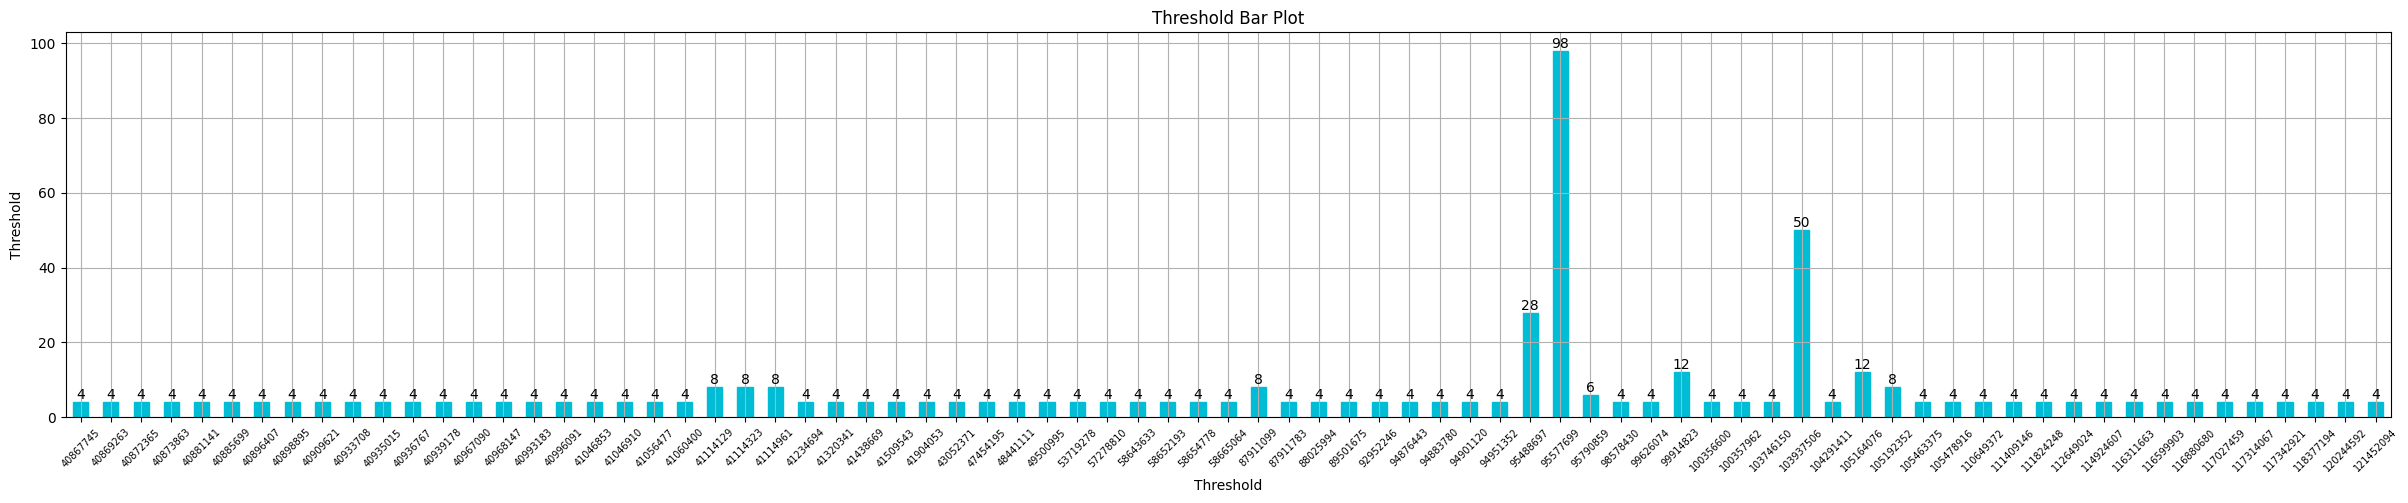

In [17]:
threshold_series = df_stats.groupby('entry_id_')['threshold'].nth(1)
threshold_series = threshold_series.astype(np.double)
mask = np.isfinite(threshold_series)
threshold_series = threshold_series[mask]
# threshold_series.replace([np.inf, -np.inf], np.nan, inplace = True)
# threshold_series = threshold_series.astype(float)

ax = threshold_series.plot.bar(
    figsize = (30,5), title = 'Threshold Bar Plot', 
    fontsize = 10, color='#00bcd4', edgecolor='#00bcd4', linestyle='-',
    legend = False, grid = True, xlabel = 'entry_id', ylabel = 'Threshold'
)
ax.bar_label(ax.containers[0])
plt.xticks(fontsize = 7, rotation = 45)

# ax = threshold_series.plot.hist(
#     figsize=(30, 5), bins = 100, title='Frequency of thresholds', 
#     fontsize=10, color='#00bcd4', edgecolor='g', linestyle='-',
# )
ax.set_xlabel('Threshold')
plt.style.use('default')
plt.show()

In [18]:
df_stats_pivot = df_stats.pivot_table(['price_avg', 'alarm2', 'as_is_alarm2'], columns = ['date'], index = ['entry_id_'])

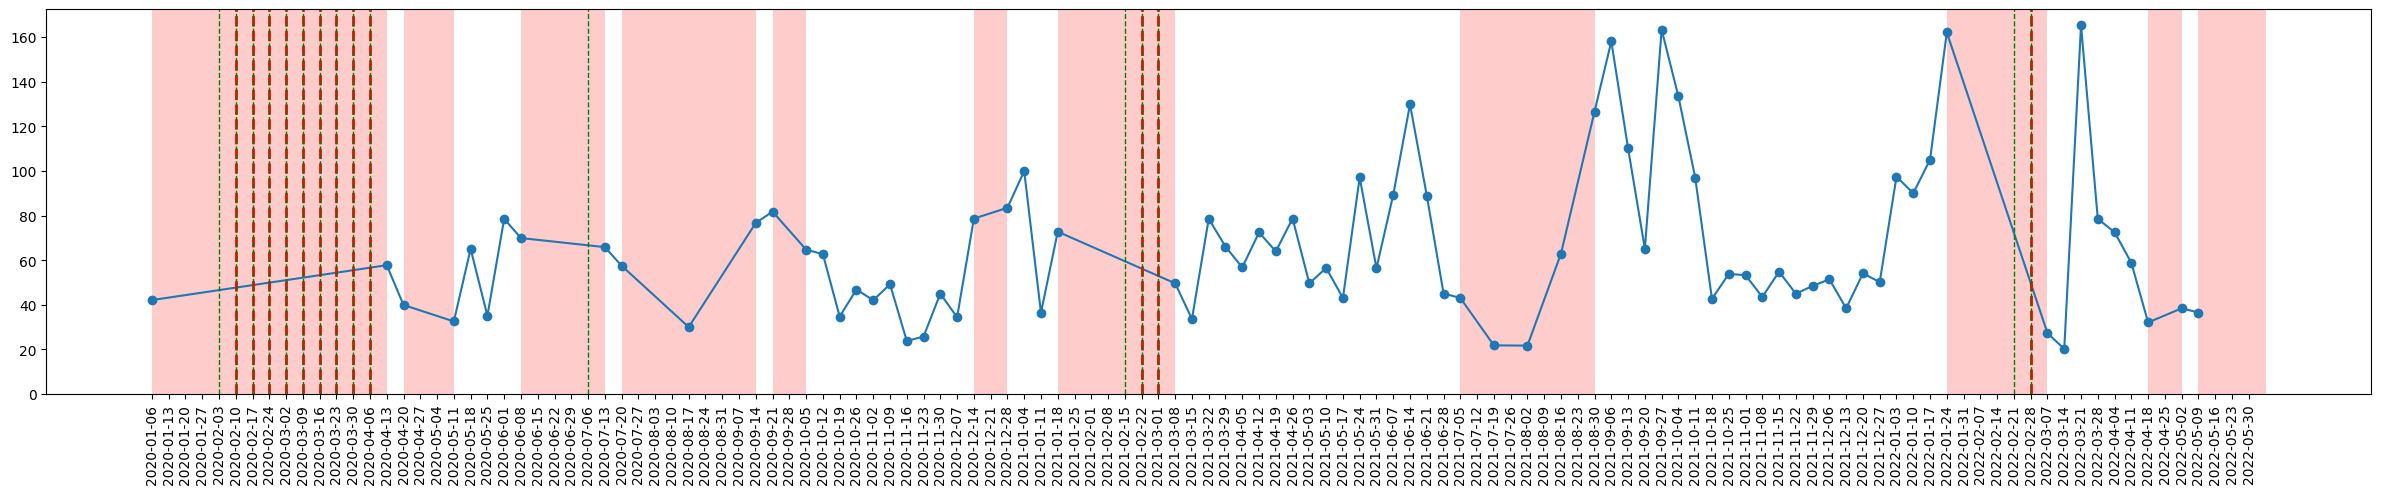

In [39]:
# Define function: Plot sample data with full time period
entry = 58652193
def plot_sample_with_ft(df_pivot, entry_id):
    # Masking null_value
    sample_entry = df_pivot[df_pivot.index == entry_id].stack(dropna = False).reset_index().drop(['entry_id_'], axis = 1)
    x = sample_entry.date
    y = sample_entry.price_avg.astype(np.double)
    alarm2_x = sample_entry[sample_entry['alarm2'] == 1].date
    as_is_alarm2_x = sample_entry[sample_entry['as_is_alarm2'] == 1].date
    ymask = np.isfinite(y)
    
    plt.figure(figsize = (30, 5))
    plt.plot(x[ymask], y[ymask], linestyle = '-', marker = 'o')
    for i in range(len(alarm2_x)):
        plt.axvline(x=alarm2_x.iat[i], color='r', linestyle='--', linewidth=2, label = 'new_alarm2')
    for i in range(len(as_is_alarm2_x)):
        plt.axvline(x=as_is_alarm2_x.iat[i], color='g', linestyle='--', linewidth=1, label = 'as_is_alarm2')
    plt.xticks(sample_entry.date, rotation = 90)
    plt.ylim(bottom = 0)
    
    # axvspan with red color - find index of start & end point of null

    sample_entry = sample_entry.set_index('date')
    is_nan = sample_entry['price_avg'].isna()
    n_groups = is_nan.ne(is_nan.shift()).cumsum()
    
    if len(sample_entry[is_nan].groupby(n_groups).groups) > 1:
        gap_list = sample_entry[is_nan].groupby(n_groups).aggregate(
            lambda x: (
                x.index[0] + pd.DateOffset(days=-7),
                x.index[-1] + pd.DateOffset(days=+7)
            )
        )["price_avg"].values
    
        for gap in gap_list:
            plt.axvspan(gap[0], gap[1], facecolor='r', alpha=0.2)
        
    plt.style.use('default')
    plt.show()

plot_sample_with_ft(df_pivot = df_stats_pivot, entry_id = entry)

In [38]:
reported_regularly

[40867745,
 40869263,
 40872365,
 40873863,
 40881141,
 40885699,
 40896407,
 40898895,
 40909621,
 40933708,
 40935015,
 40936767,
 40939178,
 40967090,
 40968147,
 40993183,
 40996091,
 41046853,
 41046910,
 41056477,
 41060400,
 41234694,
 41320341,
 41438669,
 41509543,
 41904053,
 43052371,
 47454195,
 48441111,
 49500995,
 53719278,
 57278810,
 58643633,
 58652193,
 58654778,
 58665064,
 87911783,
 88025994,
 89501675,
 92952246,
 94876443,
 94883780,
 94901120,
 94951352,
 98578430,
 99626074,
 100356600,
 100357962,
 103746150,
 104291411,
 105192352,
 105463375,
 105478916,
 110649372,
 111409146,
 112649024,
 114924607,
 116311663,
 116599903,
 116880680,
 117027459,
 117314067,
 117342921,
 118377194,
 120244592,
 121452094]